In [1]:
import numpy as np
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
from sklearn.preprocessing import RobustScaler
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

2024-11-26 21:52:00.433272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 21:52:00.433331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 21:52:00.434636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 21:52:00.442529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 21:52:01.454484: W tensorflow/compiler/tf2

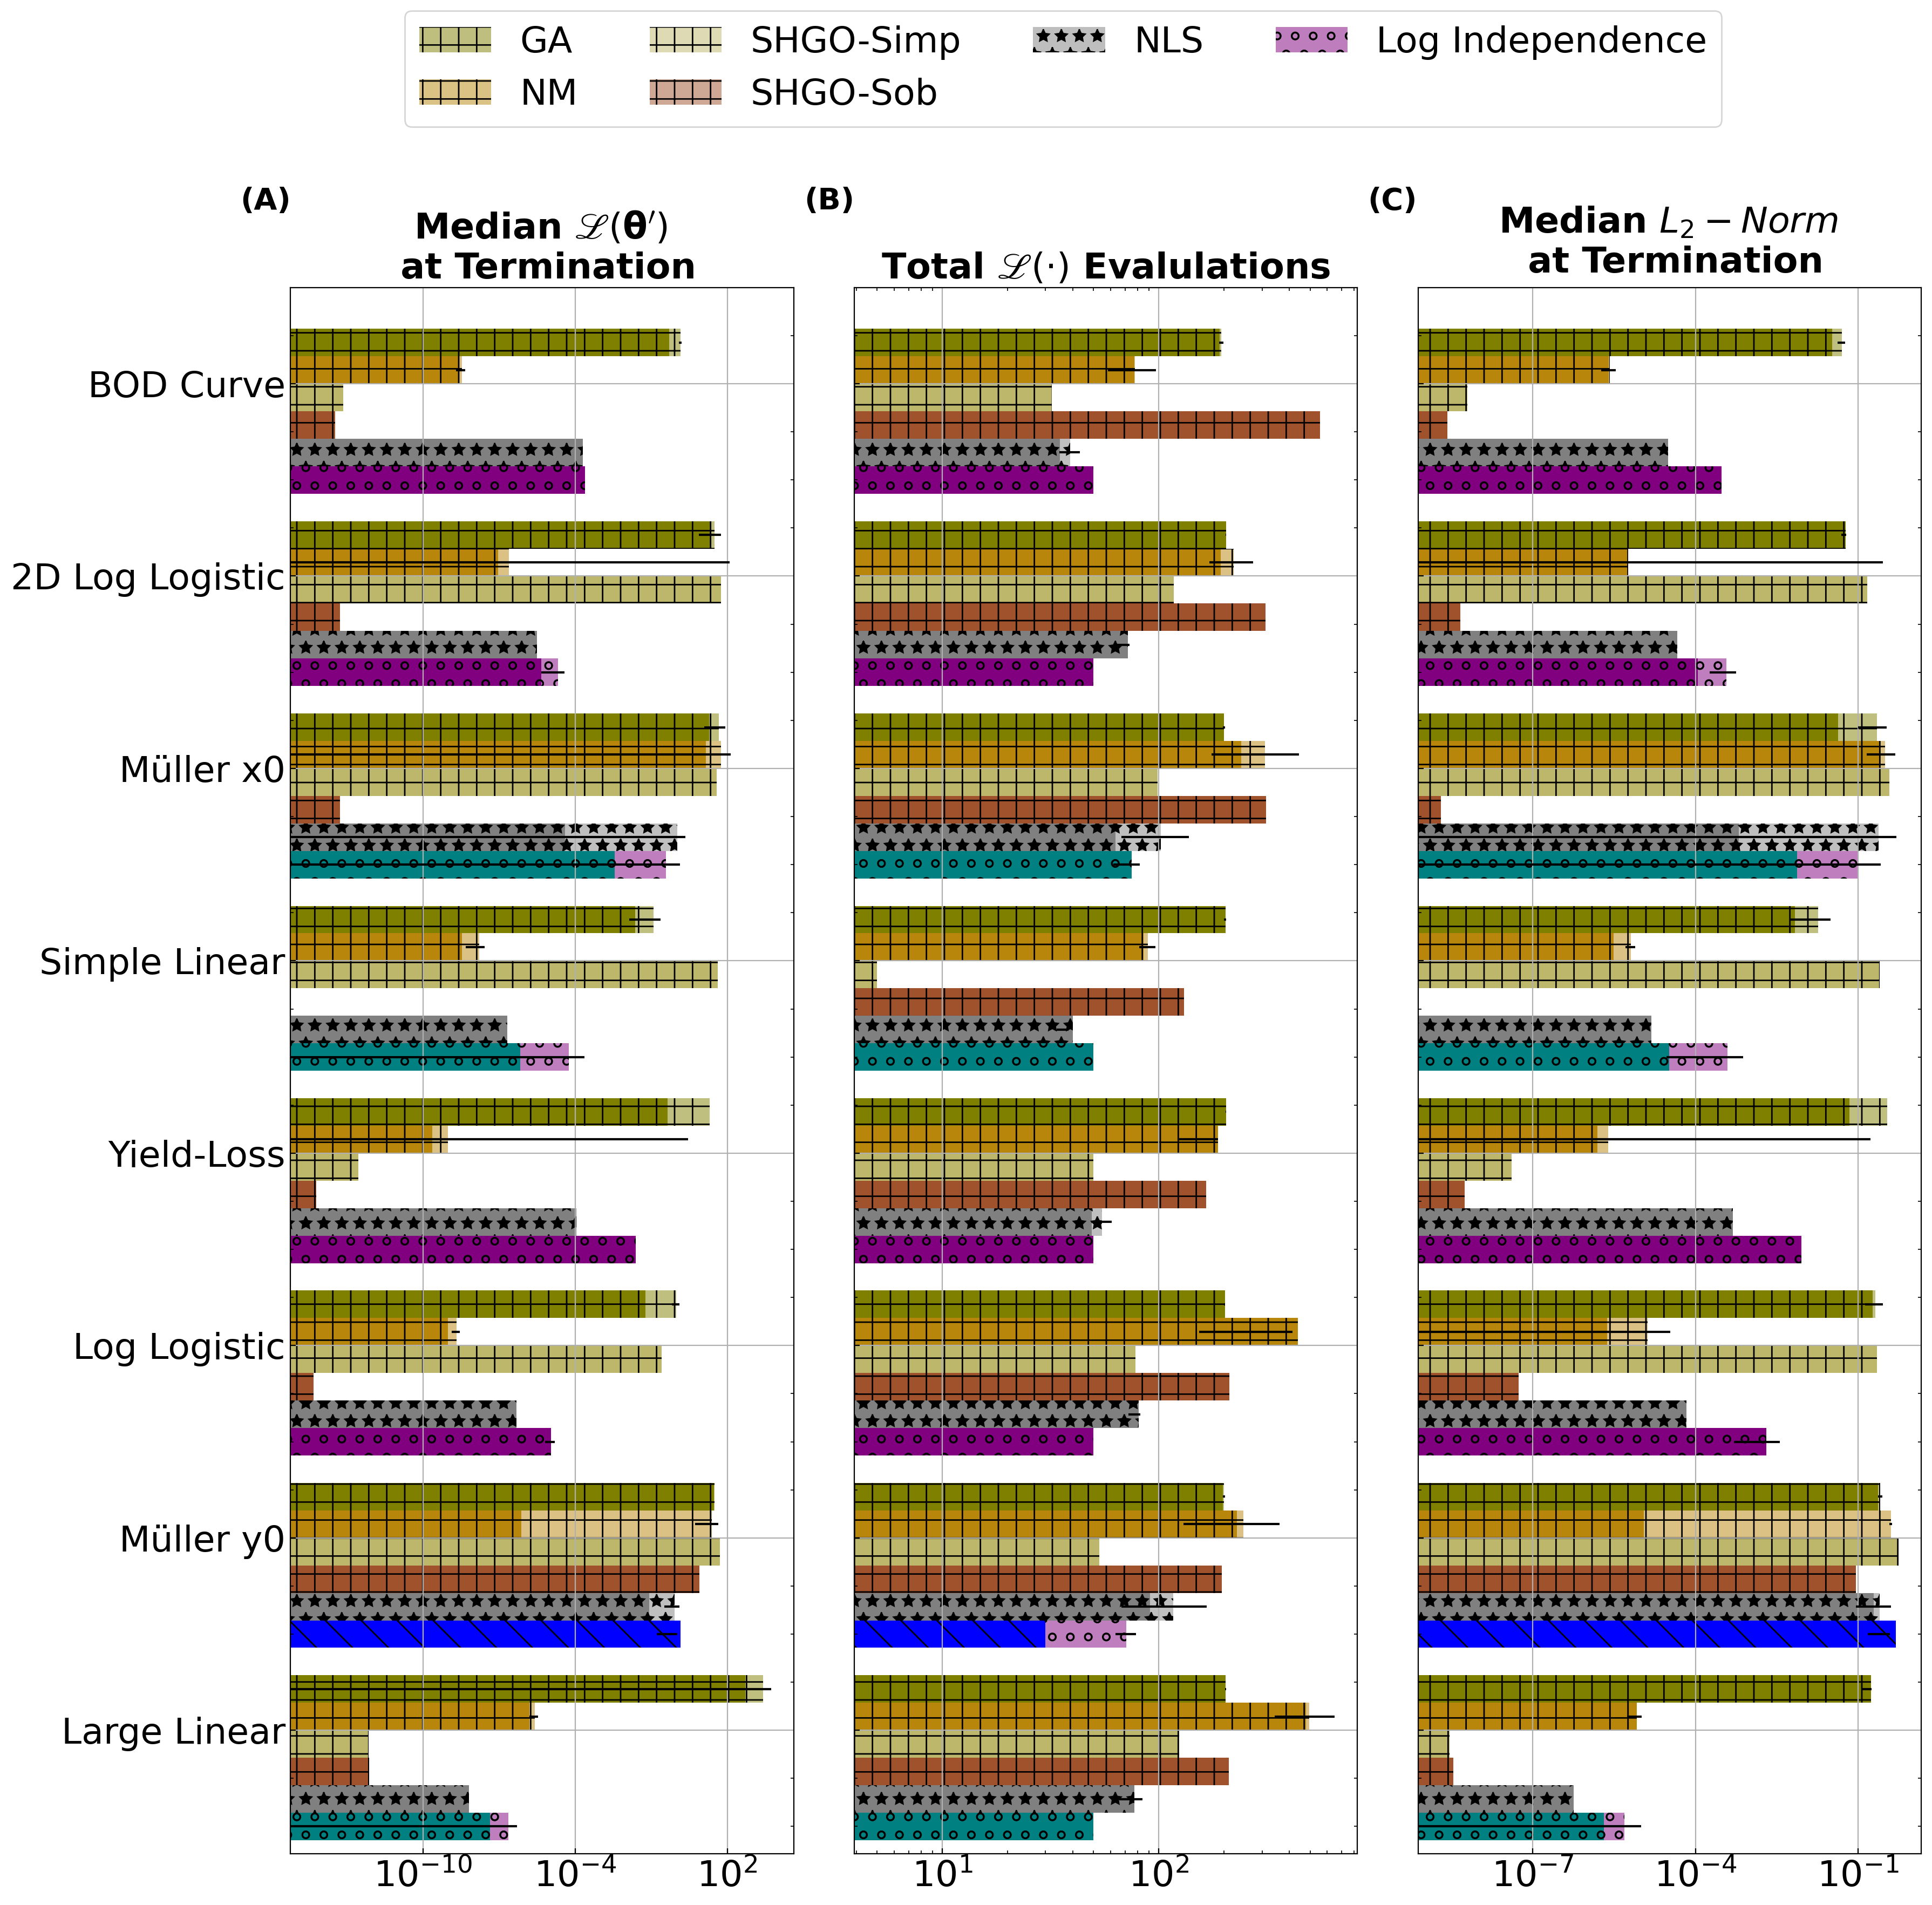

In [2]:
from bo_methods_lib.bo_methods_lib.analyze_data import All_CS_Analysis
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import All_CS_Plotter

#Ignore warnings
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

#Set parameters
meth_list = [1,2,3,4,5,6,7]
cs_list = [11,14,2,1,12,13,3,10]
save_csv = False #Set to False if you don't want to save/resave csvs
save_figs = False
bar_modes = ["objs"] #time and/or objs
project = signac.get_project("GPBO_Fix")

analyzer = All_CS_Analysis(cs_list, meth_list, project, "act", save_csv)
plotters = All_CS_Plotter(analyzer, save_figs)

#Get % true found
#Change cs_list here to get averages over select case studies
# analyzer.get_percent_true_found(cs_list)

#Make Parity Plots
for bmode in bar_modes:
    # df_average = plotters.make_bar_charts(bmode)
    df_average = plotters.make_derivfree_bar(s_meths = ["NLS", "SHGO-Sob", "SHGO-Simp", "NM", "GA"])

In [ ]:
# Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(1,0,0, 1)

# Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1  # Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(2)
num_pts = 100
exp_data = simulator.gen_exp_data(num_pts, gen_meth_x, 1)

# Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals)) * 0.05

In [ ]:
print(exp_data.y_vals)

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(exp_data.x_vals, exp_data.y_vals, color='blue', linestyle='-', linewidth=2)

# Add labels and title
ax.set_xlabel('X-Value')
ax.set_ylabel('Y-Value')
ax.set_title('BOD Curve Example')

# Add grid
ax.grid(True)

# Add legend
# ax.legend()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample 2D data
X, Y = exp_data.x_vals.reshape(num_pts, num_pts,2).T
Z = exp_data.y_vals.reshape(X.shape)

# Create the plot
fig, ax = plt.subplots()

# Plot filled contours with contourf
contour_filled = ax.contourf(X, Y, Z, levels=20, cmap='jet')

# Add contour lines
contour_lines = ax.contour(X, Y, Z, levels=20, colors='black', linestyle = '--', linewidths=0.5)

# Add a colorbar for the filled contours
cbar = fig.colorbar(contour_filled, ax=ax)
cbar.set_label('Magnitude')

# Add labels to the contour lines
ax.clabel(contour_lines, inline=True, fontsize=8)

# Set axis labels
ax.set_xlabel('X1')
ax.set_ylabel('X2')

# Title
ax.set_title('Müller ' + r'$x_0$' ' Data')

# Show the plot
plt.show()
